In [17]:
import numpy as np
from fireworks.ic import ic_two_body
import matplotlib.pyplot as plt
from fireworks.nbodylib.integrators import integrator_euler, integrator_leapfrog, integrator_rungekutta
from fireworks.nbodylib.dynamics import acceleration_direct_vectorized #, acceleration_direct, acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
from numpy.random import random, seed
from fireworks.particles import Particles

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

Let's put in the particles (rebember that the units are Nbody units).

In [18]:
tevolve     = 65
position    =np.array([[0.,0.,0.],[0.5, 0.866,0],[1,0,0]])
velocity    =np.array([[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]])
mass        =np.array([3.,4.,5.])
P        =Particles(position,velocity,mass)
print(P.pos )                                                                  # particles'positions
print(P.vel )                                                                  # particles'velocities
print(P.mass)                                                                  # particles'masses
print(P.ID  )                                                                  # particles'unique IDs


[[0.    0.    0.   ]
 [0.5   0.866 0.   ]
 [1.    0.    0.   ]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[3. 4. 5.]
[0 1 2]


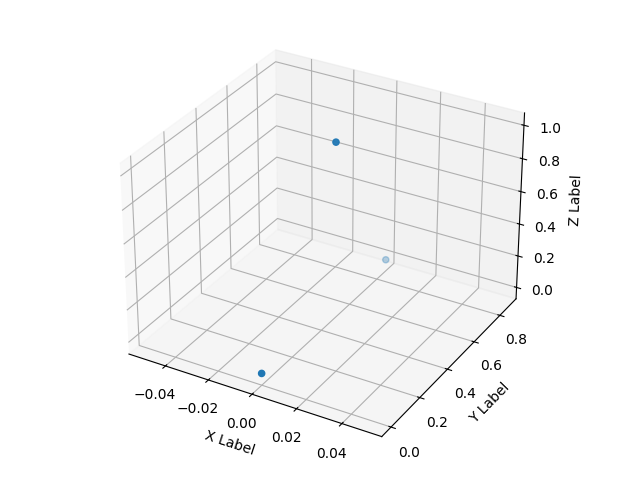

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(P.pos[0,:], P.pos[1,:], P.pos[2,:] )
#ax.scatter(P.pos[0,:], label=f'$M_1$', color='C0')
#ax.scatter(P.pos[1,:], label=f'$M_2$', color='C1')
#ax.scatter(P.pos[2,:], label=f'$M_3$', color='C2')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.tight_layout()

### TSUNAM EVOLUTION

Now we can evolve the system using the TSUNAMI integrator